In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [ ]:
zip_file_path = '/content/drive/My Drive/ecomm-multi-2019-Oct.zip'

In [ ]:
import zipfile

In [ ]:
csv_file_name = 'ecomm-multi-2019-Oct.csv'

In [ ]:
import dask.dataframe as dd

In [ ]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(csv_file_name, '/content')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/ecomm-multi-2019-Oct.zip'

In [ ]:
df_dask = dd.read_csv(f'/content/{csv_file_name}')

In [ ]:
print(df_dask.head())  # Display the first few rows
print(df_dask.info())

                event_time event_type  product_id          category_id                        category_code     brand    price    user_id                          user_session
0  2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724                                 <NA>  shiseido    35.79  541312140  72d76fde-8bb3-4e00-8c23-a032dfed738c
1  2019-10-01 00:00:00 UTC       view     3900821  2053013552326770905  appliances.environment.water_heater      aqua    33.20  554748717  9333dfbd-b87a-4708-9857-6336556b0fcc
2  2019-10-01 00:00:01 UTC       view    17200506  2053013559792632471           furniture.living_room.sofa      <NA>   543.10  519107250  566511c2-e2e3-422b-b695-cf8e6e792ca8
3  2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191                   computers.notebook    lenovo   251.74  550050854  7c90fc70-0e80-4590-96f3-13c02c18c713
4  2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655               electronics.smartphone     apple  1

In [ ]:
user_data = df_dask.groupby('user_id').agg({
    'event_type': 'count',   # Counting the number of events per user
    'price': 'mean'          # Calculating the average price per user
}).compute()

In [ ]:
user_data.columns = ['event_count', 'avg_price']

In [ ]:
Q1 = user_data['event_count'].quantile(0.25)
Q3 = user_data['event_count'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
outliers = user_data[(user_data['event_count'] < lower_bound) | (user_data['event_count'] > upper_bound)]

print("Number of outliers detected: ", outliers.shape[0])

Number of outliers detected:  353701


In [ ]:
user_data['event_count'].sum()

42448764

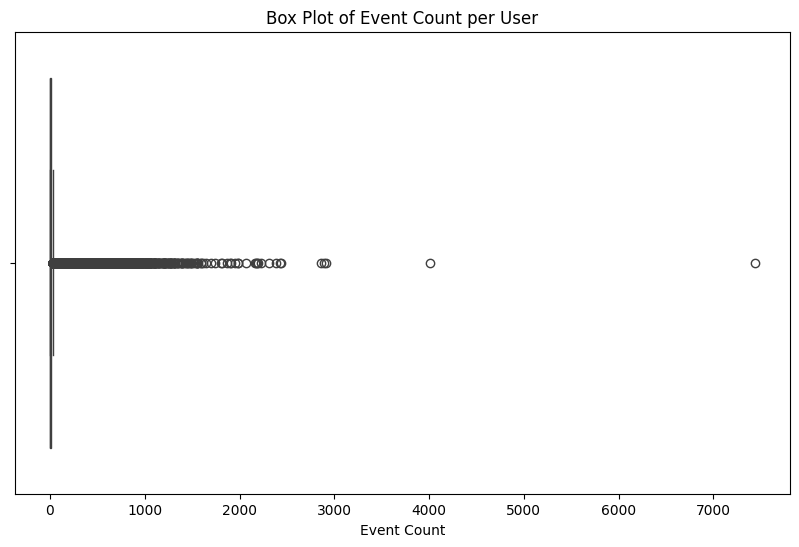

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a box plot to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=user_data, x='event_count')
plt.title('Box Plot of Event Count per User')
plt.xlabel('Event Count')
plt.show()

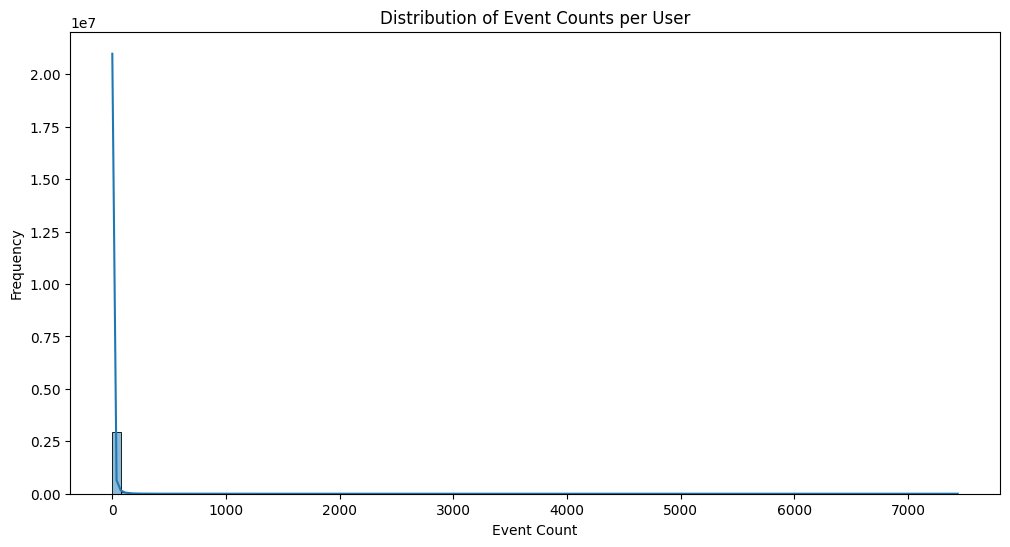

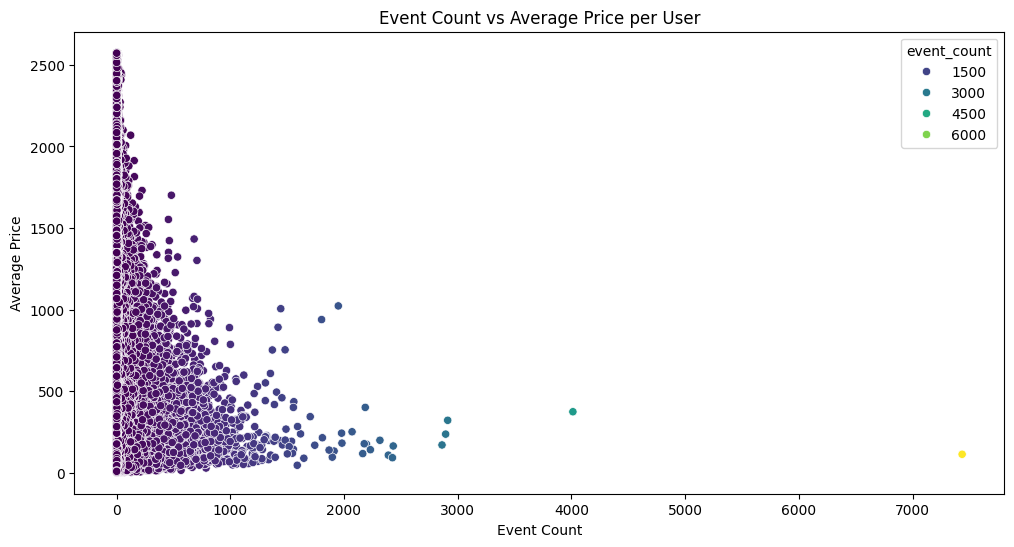

Summary Statistics for Outliers:
         event_count      avg_price
count  353701.000000  353701.000000
mean       72.054679     281.826993
std        70.927752     217.211097
min        30.000000       3.106250
25%        37.000000     134.144103
50%        51.000000     222.866027
75%        79.000000     358.921884
max      7436.000000    2451.609231
Summary Statistics for Non-Outliers:
        event_count     avg_price
count  2.668589e+06  2.668589e+06
mean   6.356525e+00  3.207781e+02
std    6.677766e+00  3.405376e+02
min    1.000000e+00  0.000000e+00
25%    1.000000e+00  9.768737e+01
50%    4.000000e+00  2.033300e+02
75%    9.000000e+00  4.104750e+02
max    2.900000e+01  2.574070e+03


In [ ]:
# Visualize the distribution of event counts
plt.figure(figsize=(12, 6))
sns.histplot(user_data['event_count'], bins=100, kde=True)
plt.title('Distribution of Event Counts per User')
plt.xlabel('Event Count')
plt.ylabel('Frequency')
plt.show()

# Scatter plot to explore the relationship between event_count and avg_price
plt.figure(figsize=(12, 6))
sns.scatterplot(data=user_data, x='event_count', y='avg_price', hue='event_count', palette='viridis')
plt.title('Event Count vs Average Price per User')
plt.xlabel('Event Count')
plt.ylabel('Average Price')
plt.show()

# Calculate summary statistics for outliers and non-outliers
outliers_summary = outliers.describe()
non_outliers_summary = user_data[~user_data.index.isin(outliers.index)].describe()

print("Summary Statistics for Outliers:")
print(outliers_summary)

print("Summary Statistics for Non-Outliers:")
print(non_outliers_summary)

##Outliers:
Count: 353,701
Event Count: Mean of 72, with a standard deviation of 70. The maximum event count is 7,436.
Average Price: Mean of 281.83, with a standard deviation of 217.21. The maximum average price is 2,451.61.
##Non-Outliers:
Count: 2,668,589
Event Count: Mean of 6.36, with a standard deviation of 6.68. The maximum event count is 29.
Average Price: Mean of 320.78, with a standard deviation of 340.54. The maximum average price is 2,574.07.

In [ ]:
user_data_filtered = user_data[~user_data.index.isin(outliers.index)]
filtered_user_ids = user_data_filtered.index.tolist()

In [ ]:
df_filtered = df_dask[df_dask['user_id'].isin(filtered_user_ids)]


In [ ]:
unique_user_ids = df_filtered['user_id'].unique().compute()

In [ ]:
sampled_user_ids = np.random.choice(unique_user_ids, size=int(0.1 * len(unique_user_ids)), replace=False)

In [ ]:
sampled_user_ids_list = sampled_user_ids.tolist()

In [ ]:
df_sampled = df_filtered[df_filtered['user_id'].isin(sampled_user_ids_list)]

In [ ]:
df_sampled = df_sampled.compute()

In [ ]:
df_sampled.head()

event_time event_type  product_id          category_id                      category_code    brand   price    user_id                          user_session
24   2019-10-01 00:00:23 UTC       view     6200260  2053013552293216471  appliances.environment.air_heater    midea   47.62  538645907  7d9a8784-7b6c-426e-9924-9f688812fd71
48   2019-10-01 00:00:36 UTC       view     2900475  2053013554776244595       appliances.kitchen.microwave  gorenje  295.99  533078094  6eaaf55a-7bbe-4b3d-95a8-f3b3e31c39c8
62   2019-10-01 00:00:50 UTC       view    28717211  2053013565882762215                               <NA>  respect   76.96  555447577  4337a670-6520-4159-aff4-fd620d2599f9
67   2019-10-01 00:00:56 UTC       view     4804295  2053013554658804075        electronics.audio.headphone   xiaomi   23.13  541366014  6d8ce6fb-2953-4e95-96fe-b40f1ec50ba8
101  2019-10-01 00:01:29 UTC       view     1801551  2053013554415534427               electronics.video.tv    haier  463.31  515511944  d63ef339-2d6a-411a-95bd-d58c77ae6e4f

         product_id   category_id         price       user_id
count  1.694677e+06  1.694677e+06  1.694677e+06  1.694677e+06
mean   9.969456e+06  2.057404e+18  3.111036e+02  5.379338e+08
std    1.174040e+07  1.858416e+16  3.806787e+02  1.906532e+07
min    1.000978e+06  2.053014e+18  0.000000e+00  2.229075e+08
25%    1.005102e+06  2.053014e+18  7.053000e+01  5.187224e+08
50%    4.802593e+06  2.053014e+18  1.720600e+02  5.394320e+08
75%    1.510020e+07  2.053014e+18  3.763800e+02  5.566735e+08
max    6.050000e+07  2.175420e+18  2.574070e+03  5.662804e+08


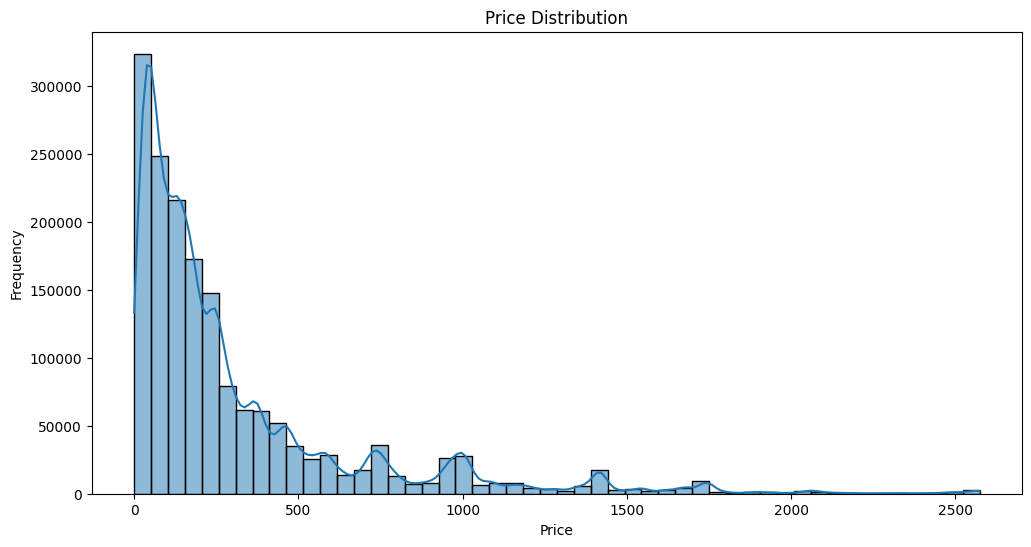

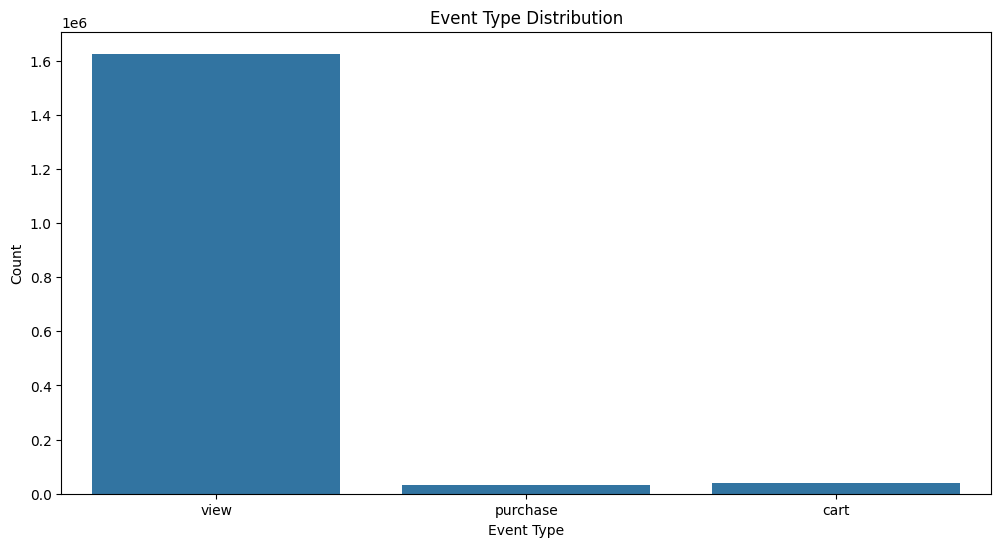

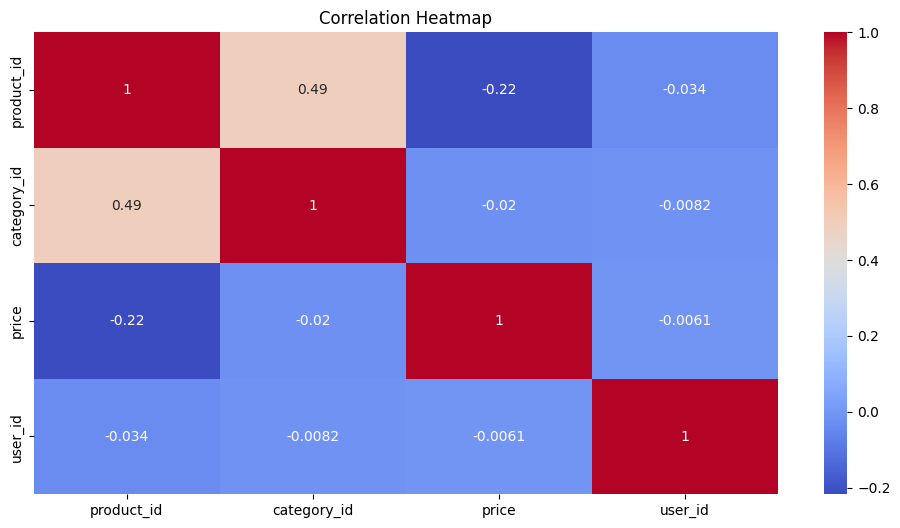

In [ ]:
# Ensure the sampled data is in a Pandas DataFrame format
df_sampled = pd.DataFrame(df_sampled)

# Summary statistics
print(df_sampled.describe())

# Plotting distributions
plt.figure(figsize=(12, 6))
sns.histplot(df_sampled['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Event type counts
plt.figure(figsize=(12, 6))
sns.countplot(data=df_sampled, x='event_type')
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

# Selecting only numeric columns for correlation heatmap
numeric_columns = df_sampled.select_dtypes(include=['float64', 'int64']).columns

# Correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_sampled[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Display the first few rows
print(df_sampled.head())

# Summary statistics
print(df_sampled.describe(include='all'))

# Check for missing values
print(df_sampled.isnull().sum())

# Data types of each column
print(df_sampled.dtypes)


                  event_time event_type  product_id          category_id                      category_code    brand   price    user_id                          user_session
24   2019-10-01 00:00:23 UTC       view     6200260  2053013552293216471  appliances.environment.air_heater    midea   47.62  538645907  7d9a8784-7b6c-426e-9924-9f688812fd71
48   2019-10-01 00:00:36 UTC       view     2900475  2053013554776244595       appliances.kitchen.microwave  gorenje  295.99  533078094  6eaaf55a-7bbe-4b3d-95a8-f3b3e31c39c8
62   2019-10-01 00:00:50 UTC       view    28717211  2053013565882762215                               <NA>  respect   76.96  555447577  4337a670-6520-4159-aff4-fd620d2599f9
67   2019-10-01 00:00:56 UTC       view     4804295  2053013554658804075        electronics.audio.headphone   xiaomi   23.13  541366014  6d8ce6fb-2953-4e95-96fe-b40f1ec50ba8
101  2019-10-01 00:01:29 UTC       view     1801551  2053013554415534427               electronics.video.tv    haier  463.31  5155

In [ ]:
print(df_sampled.head())
print("Number of rows in the sampled DataFrame: ", df_sampled.shape[0])
print("Number of unique user IDs in the sampled DataFrame: ", df_sampled['user_id'].nunique())

                  event_time event_type  product_id          category_id                      category_code    brand   price    user_id                          user_session
24   2019-10-01 00:00:23 UTC       view     6200260  2053013552293216471  appliances.environment.air_heater    midea   47.62  538645907  7d9a8784-7b6c-426e-9924-9f688812fd71
48   2019-10-01 00:00:36 UTC       view     2900475  2053013554776244595       appliances.kitchen.microwave  gorenje  295.99  533078094  6eaaf55a-7bbe-4b3d-95a8-f3b3e31c39c8
62   2019-10-01 00:00:50 UTC       view    28717211  2053013565882762215                               <NA>  respect   76.96  555447577  4337a670-6520-4159-aff4-fd620d2599f9
67   2019-10-01 00:00:56 UTC       view     4804295  2053013554658804075        electronics.audio.headphone   xiaomi   23.13  541366014  6d8ce6fb-2953-4e95-96fe-b40f1ec50ba8
101  2019-10-01 00:01:29 UTC       view     1801551  2053013554415534427               electronics.video.tv    haier  463.31  5155

In [ ]:
# Display the first few rows
print(df_sampled.head())

# Summary statistics
print(df_sampled.describe(include='all'))

# Check for missing values
print(df_sampled.isnull().sum())

# Data types of each column
print(df_sampled.dtypes)


                  event_time event_type  product_id          category_id                      category_code    brand   price    user_id                          user_session
24   2019-10-01 00:00:23 UTC       view     6200260  2053013552293216471  appliances.environment.air_heater    midea   47.62  538645907  7d9a8784-7b6c-426e-9924-9f688812fd71
48   2019-10-01 00:00:36 UTC       view     2900475  2053013554776244595       appliances.kitchen.microwave  gorenje  295.99  533078094  6eaaf55a-7bbe-4b3d-95a8-f3b3e31c39c8
62   2019-10-01 00:00:50 UTC       view    28717211  2053013565882762215                               <NA>  respect   76.96  555447577  4337a670-6520-4159-aff4-fd620d2599f9
67   2019-10-01 00:00:56 UTC       view     4804295  2053013554658804075        electronics.audio.headphone   xiaomi   23.13  541366014  6d8ce6fb-2953-4e95-96fe-b40f1ec50ba8
101  2019-10-01 00:01:29 UTC       view     1801551  2053013554415534427               electronics.video.tv    haier  463.31  5155

In [ ]:
df_sampled = df_sampled.dropna()  # Drop rows with any missing values (or use df_sample.fillna())

# Check again for missing values to ensure they are handled
print(df_sampled.isnull().sum())

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64


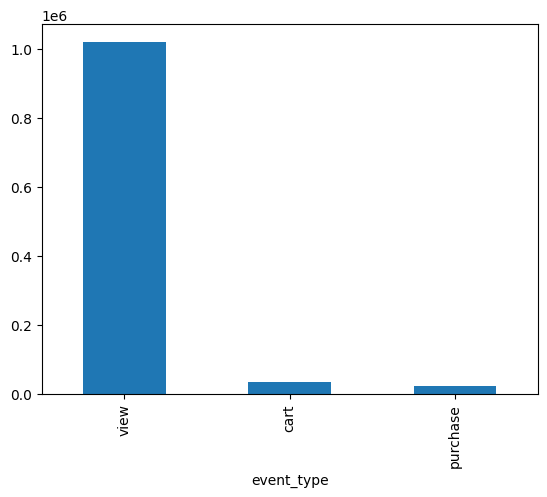

In [ ]:
df_sampled['event_type'].value_counts().plot(kind='bar')
plt.show()


In [ ]:
df_sampled['purchase_flag'] = df_sampled['event_type'] == 'purchase'

In [ ]:
# Filter views and purchases
views = df_sampled[df_sampled['event_type'] == 'view']
purchases = df_sampled[df_sampled['event_type'] == 'purchase']

# Group by category and count views and purchases
view_counts = views.groupby('category_code')['event_type'].count().reset_index(name='view_count')
purchase_counts = purchases.groupby('category_code')['event_type'].count().reset_index(name='purchase_count')

# Merge the counts
conversion = pd.merge(view_counts, purchase_counts, on='category_code', how='left')

# Replace NaN values with 0
conversion['purchase_count'].fillna(0, inplace=True)

# Calculate conversion rate
conversion['conversion_rate'] = (conversion['purchase_count'] / conversion['view_count'])

# Display the DataFrame
print(conversion)


                              category_code  view_count  purchase_count  conversion_rate
0                           accessories.bag        4376            21.0         0.004799
1                      accessories.umbrella         129             3.0         0.023256
2                        accessories.wallet         935             5.0         0.005348
3                              apparel.belt          11             0.0         0.000000
4                           apparel.costume        1453             4.0         0.002753
5                             apparel.dress        1029             0.0         0.000000
6                            apparel.jacket          21             0.0         0.000000
7                             apparel.jeans          93             0.0         0.000000
8                            apparel.jumper          97             0.0         0.000000
9                             apparel.scarf          56             0.0         0.000000
10                   

In [ ]:
conversion = conversion.dropna()

In [ ]:
conversion['conversion_rate'] = (conversion['purchase_count'] / conversion['view_count']) #make sure to add back * 100 if we want to

In [ ]:
conversion.to_csv('/content/drive/My Drive/retaildata.csv',index=False)

In [ ]:
conversion['conversion_rate'].mean()

0.009346331896686023

In [ ]:
conversion['conversion_rate'].max()

0.03202271725339796

In [ ]:
conversion.head(300)

category_code  view_count  purchase_count  conversion_rate
0                           accessories.bag        4376            21.0         0.004799
1                      accessories.umbrella         129             3.0         0.023256
2                        accessories.wallet         935             5.0         0.005348
3                              apparel.belt          11             0.0         0.000000
4                           apparel.costume        1453             4.0         0.002753
5                             apparel.dress        1029             0.0         0.000000
6                            apparel.jacket          21             0.0         0.000000
7                             apparel.jeans          93             0.0         0.000000
8                            apparel.jumper          97             0.0         0.000000
9                             apparel.scarf          56             0.0         0.000000
10                            apparel.shirt         697             1.0         0.001435
11                            apparel.shoes       20145            85.0         0.004219
12               apparel.shoes.ballet_shoes          82             0.0         0.000000
13                apparel.shoes.espadrilles          69             0.0         0.000000
14                       apparel.shoes.keds       13817            68.0         0.004921
15                  apparel.shoes.moccasins         493             0.0         0.000000
16                    apparel.shoes.sandals         242             0.0         0.000000
17                    apparel.shoes.slipons         197             0.0         0.000000
18                   apparel.shoes.step_ins          45             0.0         0.000000
19                           apparel.shorts          13             0.0         0.000000
20                            apparel.skirt          34             0.0         0.000000
21                             apparel.sock          71             0.0         0.000000
22                         apparel.trousers         317             1.0         0.003155
23                           apparel.tshirt         534             0.0         0.000000
24                        apparel.underwear        2107             1.0         0.000475
25   appliances.environment.air_conditioner        1600            18.0         0.011250
26        appliances.environment.air_heater        4204            77.0         0.018316
27               appliances.environment.fan          78             1.0         0.012821
28            appliances.environment.vacuum       27304           547.0         0.020034
29      appliances.environment.water_heater        5921           130.0         0.021956
30                          appliances.iron        5503           139.0         0.025259
31                 appliances.ironing_board         968            23.0         0.023760
32               appliances.kitchen.blender        7434           152.0         0.020447
33        appliances.kitchen.coffee_grinder         393            10.0         0.025445
34        appliances.kitchen.coffee_machine        3399            17.0         0.005001
35            appliances.kitchen.dishwasher        2854            20.0         0.007008
36                 appliances.kitchen.grill        2959            23.0         0.007773
37                   appliances.kitchen.hob        2670            15.0         0.005618
38                  appliances.kitchen.hood        3088            18.0         0.005829
39                appliances.kitchen.juicer        1883            23.0         0.012215
40                appliances.kitchen.kettle        5064           109.0         0.021524
41          appliances.kitchen.meat_grinder        4164            88.0         0.021134
42             appliances.kitchen.microwave        5649           163.0         0.028855
43                 appliances.kitchen.mixer        2965            45.0         0.015177
44                  appli

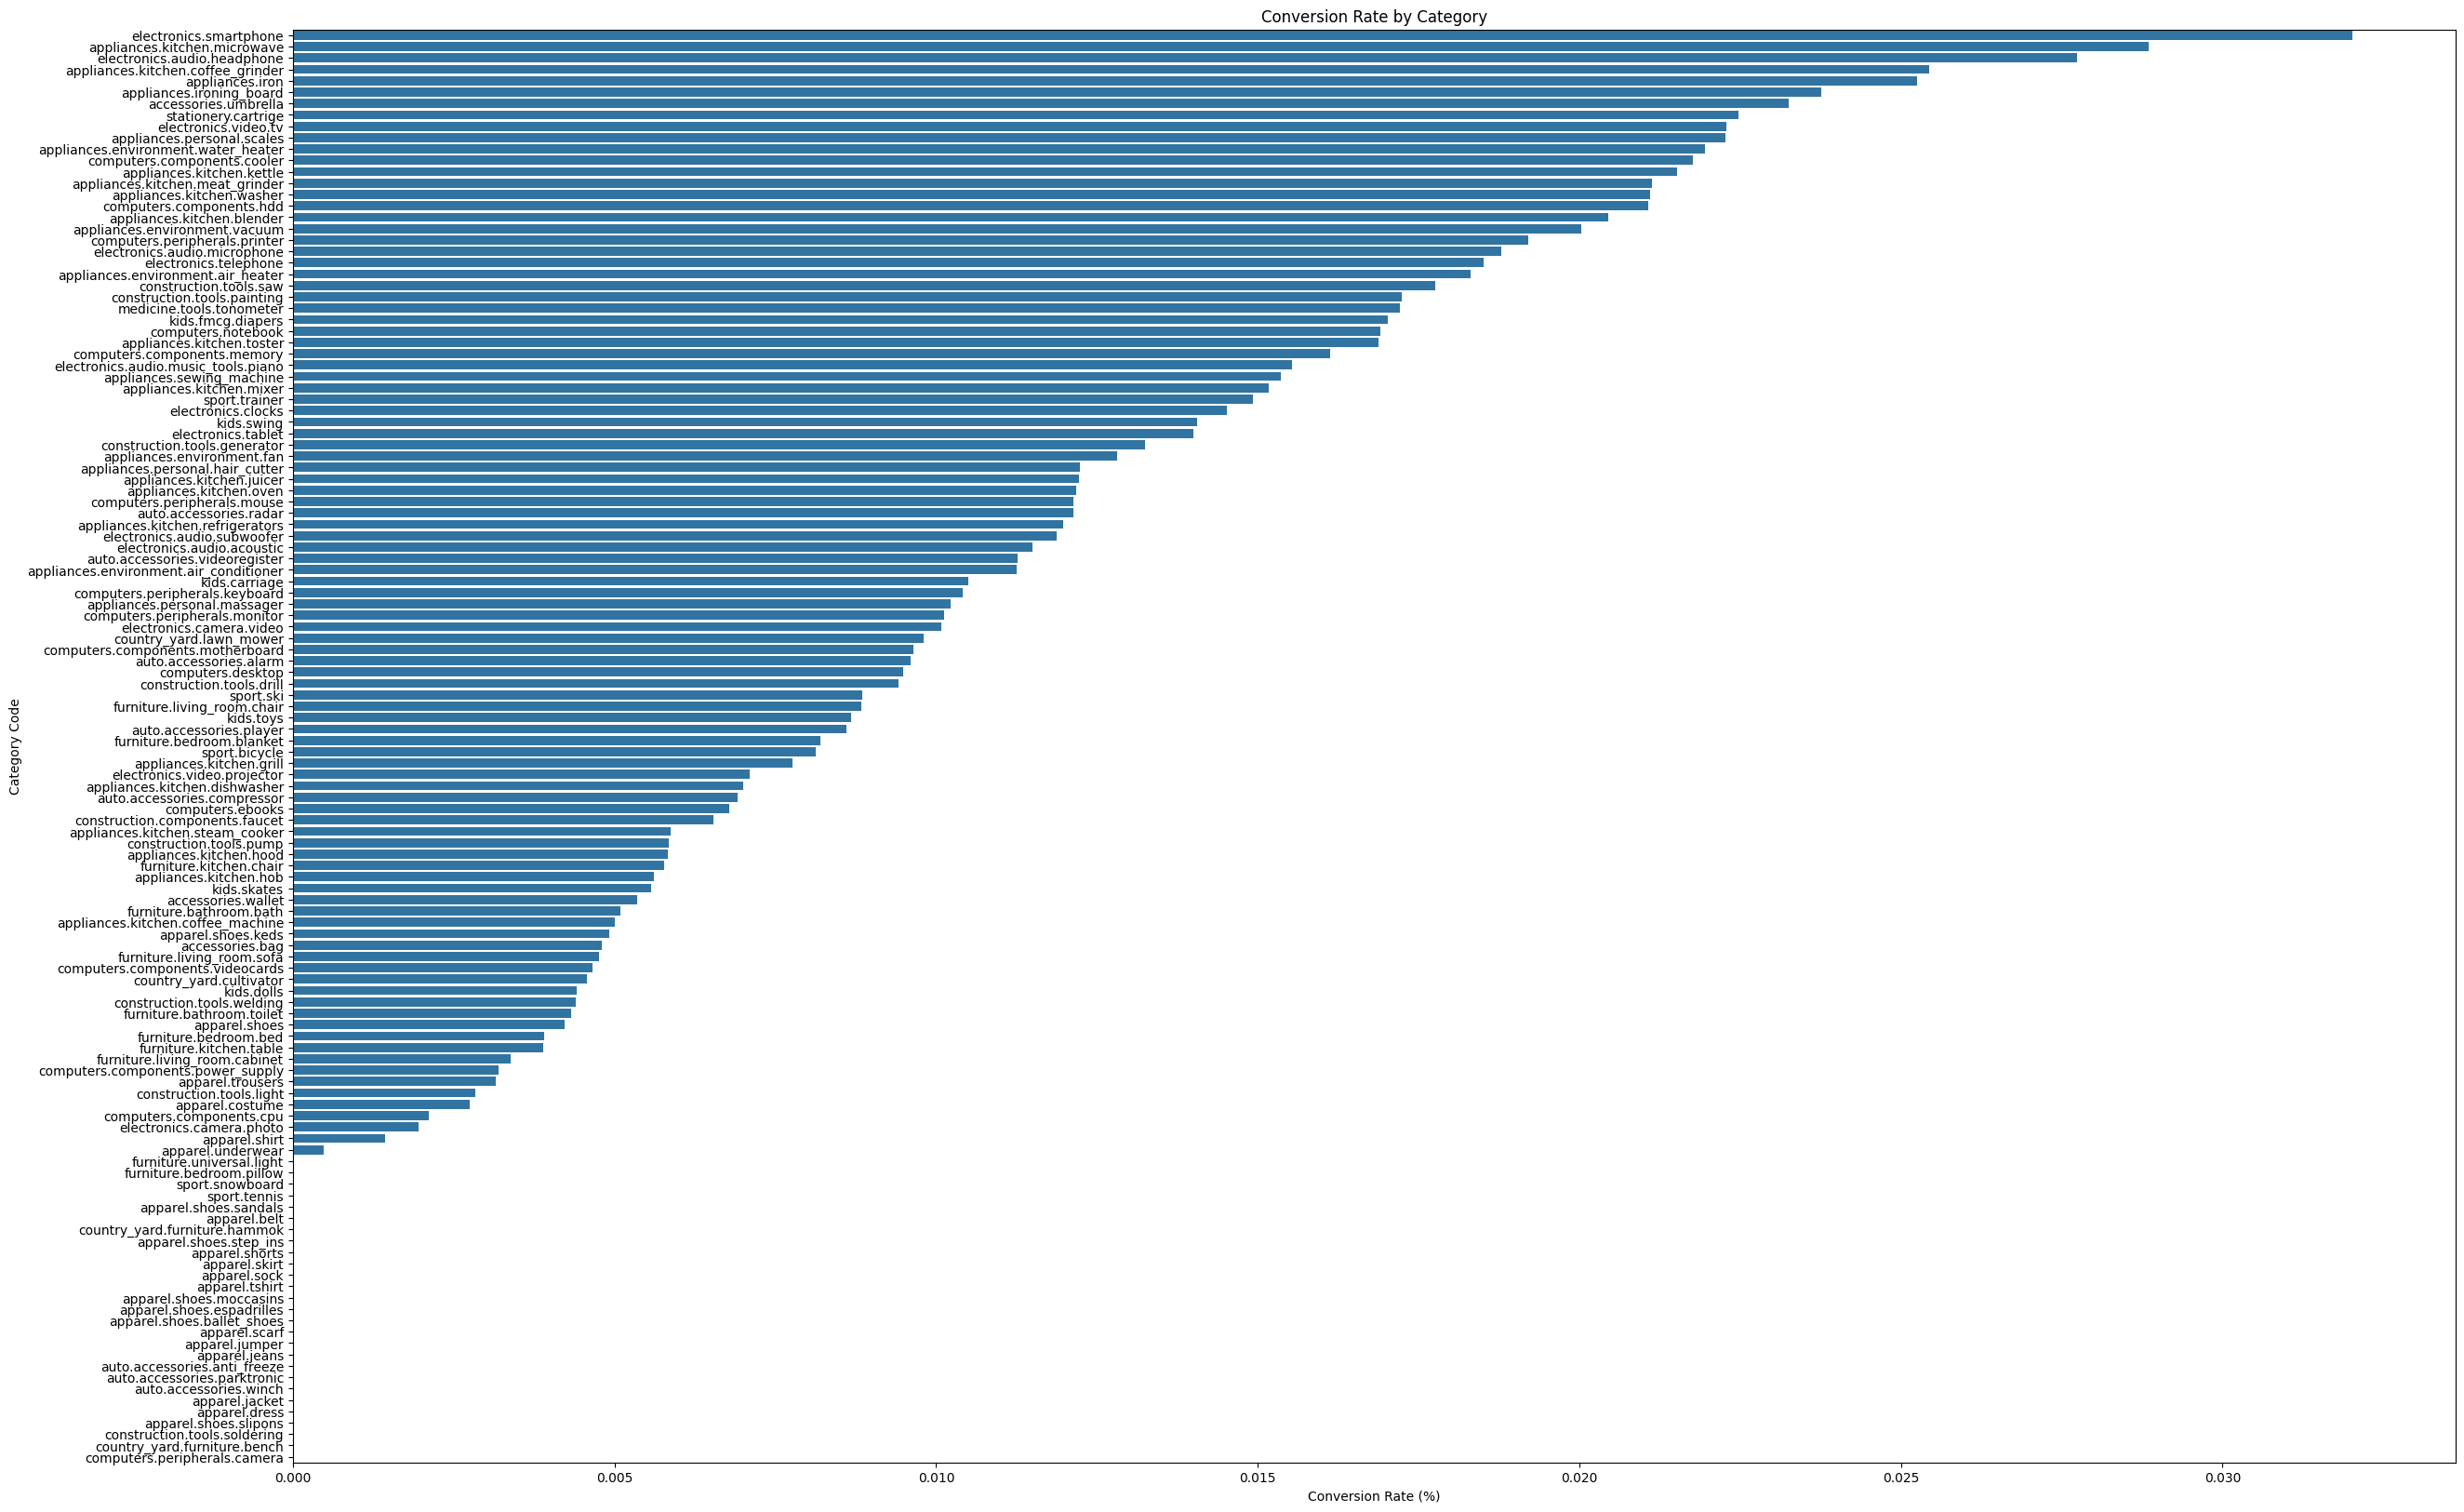

In [ ]:
import seaborn as sns

# Plot the conversion rate by category
plt.figure(figsize=(30, 20))
sns.barplot(x='conversion_rate', y='category_code', data=conversion.sort_values(by='conversion_rate', ascending=False))
plt.xlabel('Conversion Rate (%)')
plt.ylabel('Category Code')
plt.title('Conversion Rate by Category')
plt.show()

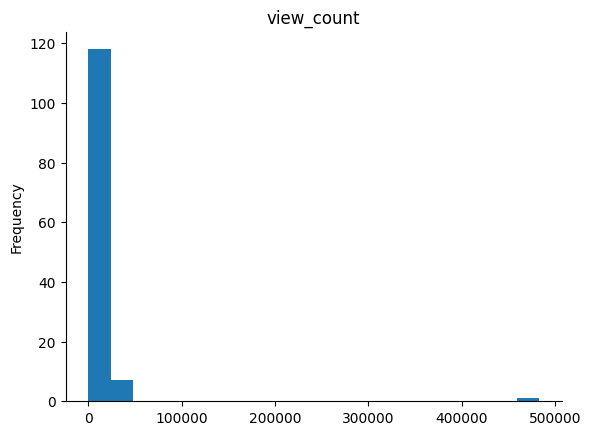

In [ ]:
# @title view_count

from matplotlib import pyplot as plt
conversion['view_count'].plot(kind='hist', bins=20, title='view_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
conversion['view_count'].sum()


1019266

In [ ]:
df_sampled['event_time'] = pd.to_datetime(df_sampled['event_time']) # Run pas

In [ ]:
df_sampled['is_purchase'] = df_sampled['event_type'].apply(lambda x: 1 if x == 'purchase' else 0) # Run pas

In [ ]:
user_data = df_sampled.groupby('user_id').agg({ 'event_type': lambda x: (x == 'view').sum(), 'price': 'mean', 'is_purchase': 'max' }).reset_index()

user_data.columns = ['user_id', 'views', 'avg_price', 'is_purchase'] #Run pas

In [ ]:
import pandas as pd

# Assuming df_sampled is already defined and contains all necessary columns

# Aggregate the features
user_data = df_sampled.groupby('user_id').agg({
    'event_type': lambda x: (x == 'view').sum(),
    'price': 'mean',
    'is_purchase': 'max',
    'category_id': lambda x: x.mode()[0],
    'product_id': lambda x: x.mode()[0],
    'brand': lambda x: x.mode()[0]
}).reset_index()

# Calculate additional features
user_data['distinct_products_viewed'] = df_sampled.groupby('user_id')['product_id'].nunique().values
user_data['time_since_first_view'] = (df_sampled.groupby('user_id')['event_time'].max() - df_sampled.groupby('user_id')['event_time'].min()).dt.total_seconds().values

# Rename the columns
user_data.columns = ['user_id', 'views', 'avg_price', 'is_purchase', 'category_id', 'product_id', 'brand', 'distinct_products_viewed', 'time_since_first_view']

# Ensure there are no missing values in 'views'
assert user_data['views'].isnull().sum() == 0, "There should be no missing values in views."


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Regression 1 (views, purchase) without SMOTE

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Prepare data
X = user_data[['views', 'avg_price']]
y = user_data['is_purchase']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     36493
           1       0.00      0.00      0.00      3261

    accuracy                           0.92     39754
   macro avg       0.46      0.50      0.48     39754
weighted avg       0.84      0.92      0.88     39754

ROC-AUC Score: 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Logistic Regression 2 (views, price, time, distinct view) without SMOTE

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

# Define features and target
X1 = user_data[['views', 'avg_price', 'distinct_products_viewed', 'time_since_first_view', 'category_id', 'product_id', 'brand']]
y2 = user_data['is_purchase']

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['views', 'avg_price', 'distinct_products_viewed', 'time_since_first_view']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['category_id', 'product_id', 'brand'])
    ])

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=500))  # Increased max_iter
])

# Split the data
X1_train, X1_test, y2_train, y2_test = train_test_split(X1, y2, test_size=0.2, random_state=42)

# Train the Logistic Regression model
pipeline.fit(X1_train, y2_train)

# Predict on the test set
y2_pred = pipeline.predict(X1_test)

# Evaluate the model
print(classification_report(y2_test, y2_pred))
print("ROC-AUC Score:", roc_auc_score(y2_test, y2_pred))


              precision    recall  f1-score   support

           0       0.92      0.99      0.96     36493
           1       0.42      0.06      0.11      3261

    accuracy                           0.92     39754
   macro avg       0.67      0.53      0.53     39754
weighted avg       0.88      0.92      0.89     39754

ROC-AUC Score: 0.5283649732391033


# Logistic Regressions 1 & 2 with SMOTE

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score

# Step 1: Logistic Regression with 'views' and 'avg_price' using SMOTE

# Prepare data
X = user_data[['views', 'avg_price']]
y = user_data['is_purchase']

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['views', 'avg_price'])
    ])

# Create pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=500))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Logistic Regression with 'views' and 'avg_price' using SMOTE")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))
print()

# Step 2: Logistic Regression with additional features using SMOTE

# Define features and target
X1 = user_data[['views', 'avg_price', 'distinct_products_viewed', 'time_since_first_view', 'category_id', 'product_id', 'brand']]
y2 = user_data['is_purchase']

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['views', 'avg_price', 'distinct_products_viewed', 'time_since_first_view']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['category_id', 'product_id', 'brand'])
    ])

# Create pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=500))
])

# Split the data
X1_train, X1_test, y2_train, y2_test = train_test_split(X1, y2, test_size=0.2, random_state=42)

# Train the Logistic Regression model
pipeline.fit(X1_train, y2_train)

# Predict on the test set
y2_pred = pipeline.predict(X1_test)

# Evaluate the model
print("Logistic Regression with additional features using SMOTE")
print(classification_report(y2_test, y2_pred))
print("ROC-AUC Score:", roc_auc_score(y2_test, y2_pred))


Logistic Regression with 'views' and 'avg_price' using SMOTE
              precision    recall  f1-score   support

           0       0.95      0.75      0.84     36493
           1       0.16      0.52      0.24      3261

    accuracy                           0.74     39754
   macro avg       0.55      0.64      0.54     39754
weighted avg       0.88      0.74      0.79     39754

ROC-AUC Score: 0.6361078493770524



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression with additional features using SMOTE
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     36493
           1       0.20      0.70      0.31      3261

    accuracy                           0.74     39754
   macro avg       0.58      0.72      0.57     39754
weighted avg       0.90      0.74      0.80     39754

ROC-AUC Score: 0.7207739209864555


# Random Forest

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
import joblib
import matplotlib.pyplot as plt

# Define features and target
X1 = user_data[['views', 'avg_price', 'distinct_products_viewed', 'time_since_first_view', 'category_id', 'product_id', 'brand']]
y2 = user_data['is_purchase']

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['views', 'avg_price', 'distinct_products_viewed', 'time_since_first_view']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['category_id', 'product_id', 'brand'])
    ])

# Create pipeline with adjusted Random Forest
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=90, max_depth=40, n_jobs=-1, random_state=42))  # n_jobs=-1 uses all available cores
])

# Split the data
X1_train, X1_test, y2_train, y2_test = train_test_split(X1, y2, test_size=0.2, random_state=42)

# Train the adjusted Random Forest model
pipeline.fit(X1_train, y2_train)

# Predict on the test set
y2_pred = pipeline.predict(X1_test)

# Evaluate the model
print("Random Forest with additional features using SMOTE")
print(classification_report(y2_test, y2_pred))
print("ROC-AUC Score:", roc_auc_score(y2_test, y2_pred))

Random Forest with additional features using SMOTE
              precision    recall  f1-score   support

           0       0.97      0.66      0.79     36493
           1       0.17      0.80      0.29      3261

    accuracy                           0.67     39754
   macro avg       0.57      0.73      0.54     39754
weighted avg       0.91      0.67      0.75     39754

ROC-AUC Score: 0.7309160407174995


# See importance feature

In [ ]:
# Extracting feature importances from the trained model
import numpy as np

# Get feature names
numeric_features = ['views', 'avg_price', 'distinct_products_viewed', 'time_since_first_view']
categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(['category_id', 'product_id', 'brand'])
feature_names = np.concatenate([numeric_features, categorical_features])

# Extract feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

feature_importances_df


Feature    Importance
3                time_since_first_view  3.051143e-01
0                                views  1.643265e-01
2             distinct_products_viewed  8.039488e-02
1                            avg_price  4.087200e-02
55     category_id_2053013555631882655  4.050255e-02
15494                    brand_samsung  2.799968e-02
892                 product_id_1004856  2.016571e-02
824                 product_id_1004767  9.519108e-03
14690                      brand_apple  8.244867e-03
873                 product_id_1004833  7.615304e-03
15457                    brand_respect  7.075734e-03
902                 product_id_1004870  6.229644e-03
5868                product_id_4804056  5.378058e-03
67     category_id_2053013557192163841  4.868880e-03
5592                product_id_4802036  4.666665e-03
103    category_id_2053013561579406073  4.091707e-03
122    category_id_2053013565069067197  3.890829e-03
876                 product_id_1004836  3.756177e-03
24     category_id_2053013553341792533  3.715936e-03
15588                         brand_sv  3.571583e-03
878                 product_id_1004838  3.402460e-03
262                 product_id_1002544  3.356405e-03
15336                       brand_nike  3.237305e-03
58     category_id_2053013555816432043  3.046976e-03
101    category_id_2053013561092866779  3.044730e-03
811                 product_id_1004741  2.999099e-03
14801                        brand_brw  2.894672e-03
721                 product_id_1004505  2.853311e-03
134    category_id_2053013565639492569  2.817731e-03
39     category_id_2053013554658804075  2.537009e-03
894                 product_id_1004858  2.373982e-03
14743                      brand_baden  2.364300e-03
1050                product_id_1005100  2.360071e-03
435                 product_id_1003768  2.226841e-03
26     category_id_2053013553970938175  2.197862e-03
1065                product_id_1005115  2.177315e-03
138    category_id_2053013565782098913  2.142956e-03
15362                       brand_oppo  2.105424e-03
740                 product_id_1004565  2.103522e-03
52     category_id_2053013555464110485  2.042996e-03
15291                  brand_milavitsa  2.015652e-03
879                 product_id_1004839  1.960823e-03
92     category_id_2053013560346280633  1.957567e-03
15330                    brand_nexpero  1.910397e-03
116    category_id_2053013563911439225  1.846440e-03
15700                     brand_xiaomi  1.765685e-03
15359                    brand_oneplus  1.746472e-03
905                 product_id_1004873  1.635138e-03
143    category_id_2053013565983425517  1.619232e-03
82     category_id_2053013559792632471  1.618772e-03
15094                     brand_huawei  1.435885e-03
15402                    brand_pioneer  1.383417e-03
202    category_id_2127425436764865054  1.377549e-03
76     category_id_2053013558920217191  1.361751e-03
62     category_id_2053013556311359947  1.359739e-03
895                 product_id_1004863  1.352176e-03
41     category_id_2053013554751078769  1.314153e-03
14945                   brand_elenberg  1.306659e-03
1110                product_id_1005160  1.289636e-03
5900                product_id_4804295  1.266698e-03
29     category_id_2053013554121933129  1.228490e-03
115    category_id_2053013563877884791  1.207905e-03
14885                   brand_dauscher  1.178092e-03
66     category_id_2053013557133443581  1.124654e-03
15555                       brand_sony  1.120435e-03
25     category_id_2053013553945772349  1.107576e-03
156    category_id_2070005009382114061  1.075426e-03
126    category_id_2053013565228450757  1.072035e-03
20     category_id_2053013553140465927  1.070910e-03
14824                      brand_casio  1.058012e-03
14802                        brand_bts  1.051575e-03
4362                product_id_3700926  1.000488e-03
922                 product_id_1004903  9.960575e-04
230    category_id_2172371436436455782  9.890320e-04
117    category_id_2053013563944993659  9.830497e-04
33 

from matplotlib import pyplot as plt
feature_importances_df['Importance'].plot(kind='hist', bins=20, title='Importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature_importances_df['Importance'].plot(kind='line', figsize=(8, 4), title='Importance')
plt.gca().spines[['top', 'right']].set_visible(False)

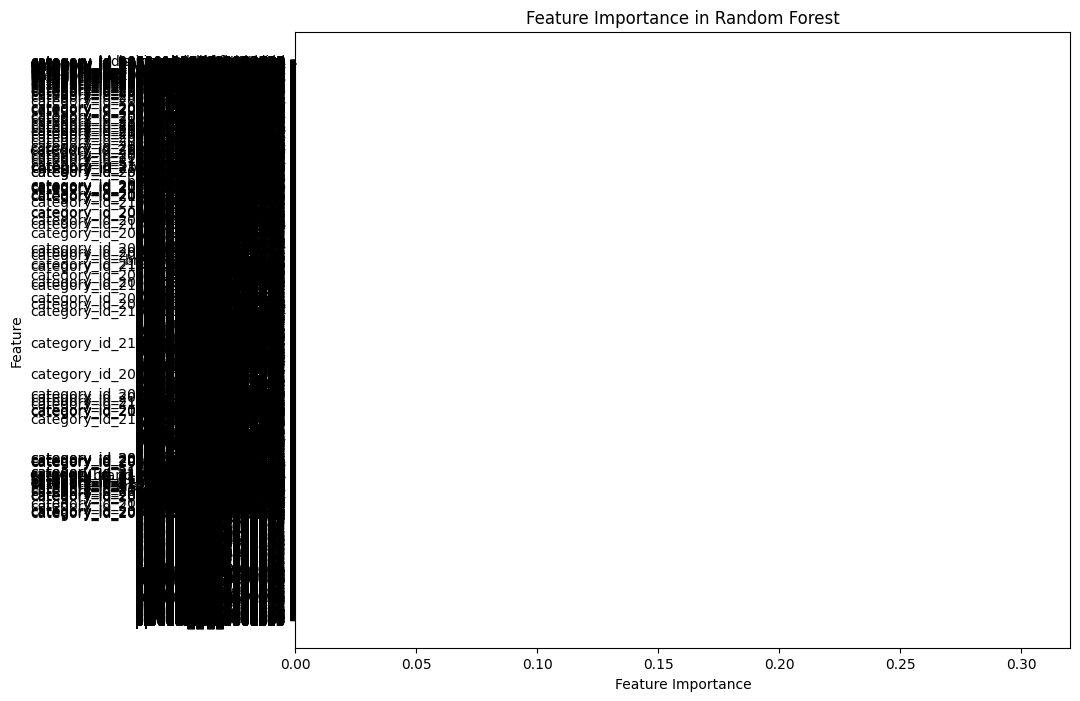

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()


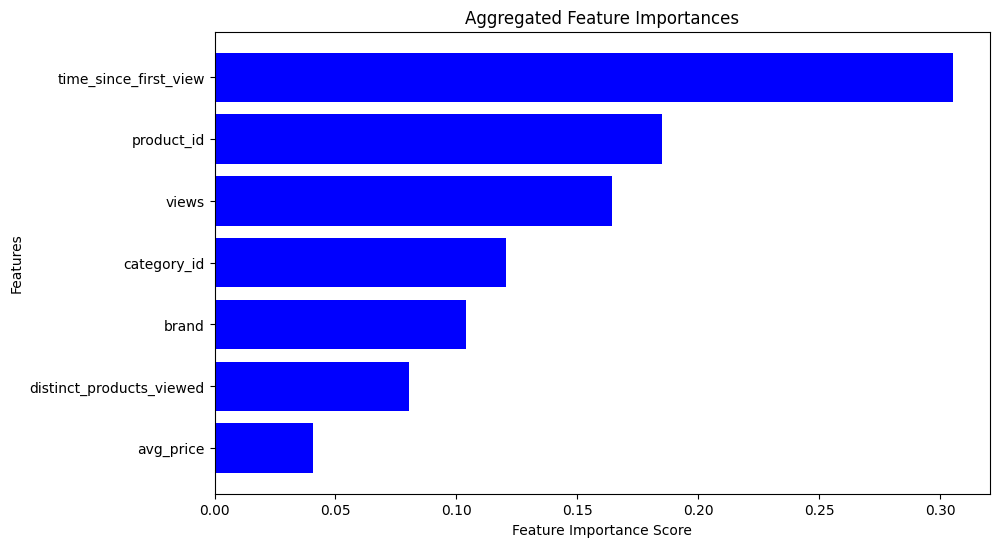

                    Feature  Importance
3     time_since_first_view    0.305114
5                product_id    0.184797
0                     views    0.164327
4               category_id    0.120460
6                     brand    0.104035
2  distinct_products_viewed    0.080395
1                 avg_price    0.040872


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Extract the trained Random Forest model from the pipeline
model = pipeline.named_steps['classifier']

# Get feature names after OneHotEncoding
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(['category_id', 'product_id', 'brand'])

# Combine numerical and categorical feature names
features = list(X1.columns[:4]) + list(cat_features)

# Get feature importances
importances = model.feature_importances_

# Aggregate importances by original feature names
feature_importance_dict = {
    'views': 0,
    'avg_price': 0,
    'distinct_products_viewed': 0,
    'time_since_first_view': 0,
    'category_id': 0,
    'product_id': 0,
    'brand': 0
}

for feature, importance in zip(features, importances):
    if 'category_id' in feature:
        feature_importance_dict['category_id'] += importance
    elif 'product_id' in feature:
        feature_importance_dict['product_id'] += importance
    elif 'brand' in feature:
        feature_importance_dict['brand'] += importance
    else:
        feature_importance_dict[feature] += importance

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame(list(feature_importance_dict.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Aggregated Feature Importances")
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='b', align='center')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()

# Display the DataFrame for feature importances
print(feature_importance_df)


              precision    recall  f1-score   support

           0       0.97      0.66      0.79     36493
           1       0.17      0.80      0.29      3261

    accuracy                           0.67     39754
   macro avg       0.57      0.73      0.54     39754
weighted avg       0.91      0.67      0.75     39754

ROC-AUC Score: 0.8046574453210364


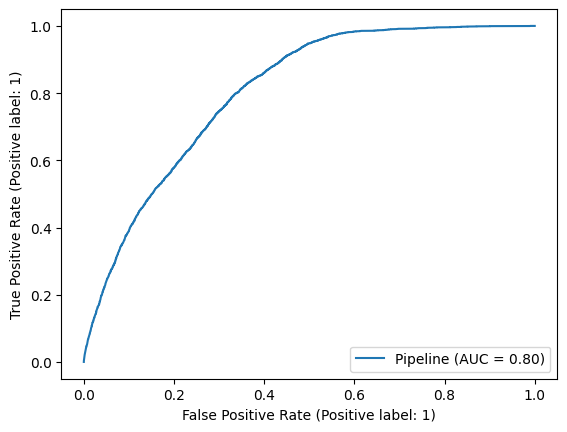

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Predict on the test set
y2_pred = pipeline.predict(X1_test)
y2_proba = pipeline.predict_proba(X1_test)[:, 1]

# Evaluate the model
print(classification_report(y2_test, y2_pred))
print("ROC-AUC Score:", roc_auc_score(y2_test, y2_proba))

# Plot ROC curve
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(pipeline, X1_test, y2_test)
plt.show()


In [ ]:
import seaborn as sns

# Calculate correlation matrix
corr_matrix = user_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


ValueError: could not convert string to float: 'moony'

In [ ]:
# Extract the trained Random Forest model from the pipeline
model = pipeline.named_steps['classifier']

# Get feature names after OneHotEncoding
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(['category_id', 'product_id', 'brand'])

# Combine numerical and categorical feature names
features = list(X1.columns[:4]) + list(cat_features)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='b', align='center')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()

# Display the DataFrame for feature importances
print(feature_importance_df)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score

# Define features and target
X1 = user_data[['views', 'avg_price', 'distinct_products_viewed', 'time_since_first_view', 'category_id', 'product_id', 'brand']]
y2 = user_data['is_purchase']

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['views', 'avg_price', 'distinct_products_viewed', 'time_since_first_view']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['category_id', 'product_id', 'brand'])
    ])

# Create pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split the data
X1_train, X1_test, y2_train, y2_test = train_test_split(X1, y2, test_size=0.2, random_state=42)

# Train the Random Forest model
pipeline.fit(X1_train, y2_train)

# Predict on the test set
y2_pred = pipeline.predict(X1_test)

# Evaluate the model
print("Random Forest with additional features using SMOTE")
print(classification_report(y2_test, y2_pred))
print("ROC-AUC Score:", roc_auc_score(y2_test, y2_pred))

# Save the model
import joblib
joblib.dump(pipeline, 'random_forest_model_with_smote.pkl')


KeyboardInterrupt: 

In [ ]:
X = user_data[['views', 'avg_price', 'distinct_products_viewed', 'time_since_first_view']]
y = user_data['is_purchase']

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train the model (Random Forest)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.82      0.86     36451
           1       0.84      0.91      0.87     36216

    accuracy                           0.87     72667
   macro avg       0.87      0.87      0.87     72667
weighted avg       0.87      0.87      0.87     72667

ROC-AUC Score: 0.8683015147132319


In [ ]:
new_user_data = pd.DataFrame({
    'views': [10, 20],
    'avg_price': [100, 200],
    'distinct_products_viewed': [5, 10],
    'time_since_first_view': [1000, 2000]
})
new_user_data = scaler.transform(new_user_data)
purchase_prob = model.predict_proba(new_user_data)[:, 1]
print(purchase_prob)

[0.48 0.42]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


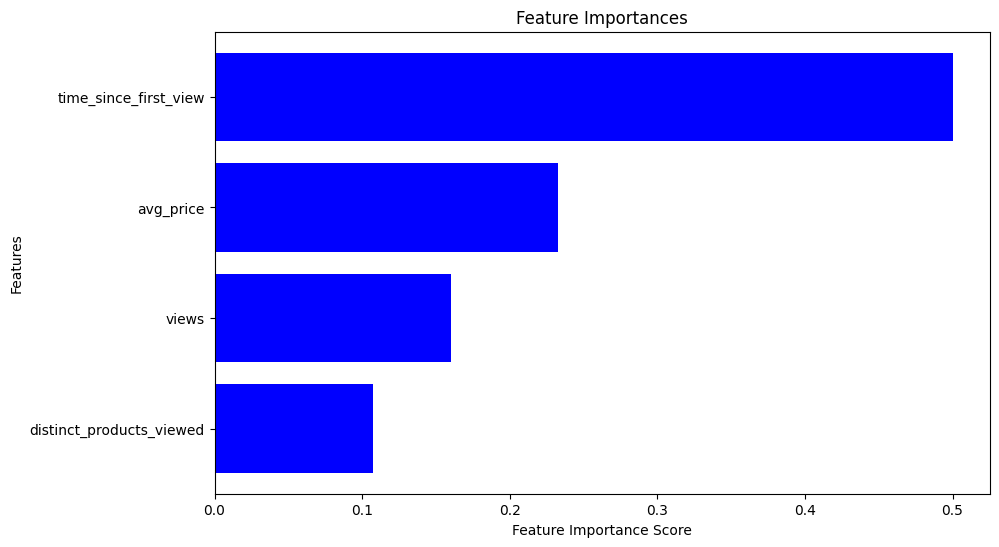

                    Feature  Importance
3     time_since_first_view    0.500079
1                 avg_price    0.232451
0                     views    0.160266
2  distinct_products_viewed    0.107204


In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
features = X.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='b', align='center')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()

# Display the DataFrame for feature importances
print(feature_importance_df)

###time_since_first_view:
This feature has the highest importance score (0.500079), indicating that the time elapsed since the user's first view is the most influential factor in predicting whether a user will make a purchase.

###avg_price:
The average price of the items viewed by the user has a significant importance score (0.232451), suggesting that the price of items plays a crucial role in determining the likelihood of a purchase.

###views:
The number of views by the user also has a notable importance score (0.160266), showing that the number of interactions a user has with products is an important predictor.

###distinct_products_viewed:
This feature has the lowest importance score (0.107204) among the four, indicating that while it still has an impact, it is less influential compared to the other features.

##Conclusion:

The time since the first view is the most critical feature, implying that the duration of user engagement might be a strong indicator of purchase intent.
The average price and the number of views are also significant, suggesting that both the price sensitivity of users and their engagement level are important factors.
Although the number of distinct products viewed is the least important, it still contributes to the prediction.

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib

# Load and preprocess your data
# Assuming user_data is your DataFrame and you have already defined 'X' and 'y'

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Standardize the features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train the model (Random Forest)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Save the model and scaler
joblib.dump(model, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [ ]:
!pip install Flask flask-ngrok joblib

In [ ]:
import joblib
model = joblib.load('random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!chmod +x ngrok


--2024-05-28 18:24:44--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 52.202.168.65, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  54.8MB/s    in 0.2s    

2024-05-28 18:24:45 (54.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
import pandas as pd
import joblib

# Initialize the Flask application
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when the app is run

# Load the trained model and scaler
model = joblib.load('random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    df = pd.DataFrame([data])
    df_scaled = scaler.transform(df)
    prediction = model.predict_proba(df_scaled)[:, 1]
    return jsonify({'purchase_probability': prediction[0]})

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-13:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 203, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 791, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urll

In [ ]:
import requests

url = 'http://<ngrok_url>/predict'  # Replace <ngrok_url> with the actual URL provided by ngrok

data = {
    "views": 10,
    "avg_price": 100,
    "distinct_products_viewed": 5,
    "time_since_first_view": 1000
}

response = requests.post(url, json=data)
print(response.json())


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.5 MB/s et

In [ ]:
import gradio as gr
import pandas as pd
import joblib

# Load the trained model and scaler
model = joblib.load('random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')

# Define the prediction function
def predict(views, avg_price, distinct_products_viewed, time_since_first_view):
    data = {
        'views': [views],
        'avg_price': [avg_price],
        'distinct_products_viewed': [distinct_products_viewed],
        'time_since_first_view': [time_since_first_view]
    }
    df = pd.DataFrame(data)
    df_scaled = scaler.transform(df)
    prediction = model.predict_proba(df_scaled)[:, 1]
    return prediction[0]

# Create the Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.components.Number(label='Views'),
        gr.components.Number(label='Average Price'),
        gr.components.Number(label='Distinct Products Viewed'),
        gr.components.Number(label='Time Since First View')
    ],
    outputs=gr.components.Textbox(label='Purchase Probability'),
    title='Purchase Probability Predictor'
)

# Launch the interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://cee59520d18396a6a8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import pandas as pd
import joblib

# Load the trained model and scaler
model = joblib.load('random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')

# Define the prediction function
def predict(views, avg_price, distinct_products_viewed, time_since_first_view):
    data = {
        'views': [views],
        'avg_price': [avg_price],
        'distinct_products_viewed': [distinct_products_viewed],
        'time_since_first_view': [time_since_first_view]
    }
    df = pd.DataFrame(data)
    print("Input DataFrame:")
    print(df)

    df_scaled = scaler.transform(df)
    print("Scaled DataFrame:")
    print(df_scaled)

    prediction = model.predict_proba(df_scaled)[:, 1]
    print("Prediction:")
    print(prediction)

    return prediction[0]

# Create the Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.components.Number(label='Views'),
        gr.components.Number(label='Average Price'),
        gr.components.Number(label='Distinct Products Viewed'),
        gr.components.Number(label='Time Since First View')
    ],
    outputs=gr.components.Textbox(label='Purchase Probability'),
    title='Purchase Probability Predictor'
)

# Launch the interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c716700a6a6b32cbb0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import pandas as pd
import joblib

# Load the trained model and scaler
model = joblib.load('random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')

# Sample test from training data (you can adjust this sample accordingly)
sample_data = pd.DataFrame({
    'views': [10, 3000],
    'avg_price': [100, 200],
    'distinct_products_viewed': [5, 10],
    'time_since_first_view': [1000, 100]
})

# Define the prediction function
def predict(views, avg_price, distinct_products_viewed, time_since_first_view):
    data = {
        'views': [views],
        'avg_price': [avg_price],
        'distinct_products_viewed': [distinct_products_viewed],
        'time_since_first_view': [time_since_first_view]
    }
    df = pd.DataFrame(data)
    print("Input DataFrame:")
    print(df)

    df_scaled = scaler.transform(df)
    print("Scaled DataFrame:")
    print(df_scaled)

    prediction = model.predict_proba(df_scaled)[:, 1]
    print("Prediction:")
    print(prediction)

    return prediction[0]

# Test the model with a sample from the training data
print("Testing model with a sample from training data:")
sample_scaled = scaler.transform(sample_data)
sample_prediction = model.predict_proba(sample_scaled)[:, 1]
print("Sample Data:")
print(sample_data)
print("Scaled Sample Data:")
print(sample_scaled)
print("Sample Prediction:")
print(sample_prediction)

# Create the Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.components.Number(label='Views'),
        gr.components.Number(label='Average Price'),
        gr.components.Number(label='Distinct Products Viewed'),
        gr.components.Number(label='Time Since First View')
    ],
    outputs=gr.components.Textbox(label='Purchase Probability'),
    title='Purchase Probability Predictor'
)

# Launch the interface
interface.launch()


Testing model with a sample from training data:
Sample Data:
   views  avg_price  distinct_products_viewed  time_since_first_view
0     10        100                         5                   1000
1   3000        200                        10                    100
Scaled Sample Data:
[[ 6.61653954e-01 -8.10207364e-01  5.14586485e-01 -6.00181077e-01]
 [ 5.47209136e+02 -5.10085561e-01  2.16562670e+00 -6.01663948e-01]]
Sample Prediction:
[0.77 0.  ]
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5d3ffec344fedc64ba.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
user_data = df_sampled.groupby('user_id').agg({
    'event_type': lambda x: (x == 'view').sum(),
    'price': 'mean',
    'is_purchase': 'max',
    'category_id': lambda x: x.mode()[0],  # Most frequent category
    'product_id': lambda x: x.mode()[0],  # Most frequent product
    'brand': lambda x: x.mode([0])
}).reset_index()

# Calculate additional features
user_data['distinct_products_viewed'] = df_sampled.groupby('user_id')['product_id'].nunique().values
user_data['time_since_first_view'] = (df_sampled.groupby('user_id')['event_time'].max() - df_sampled.groupby('user_id')['event_time'].min()).dt.total_seconds().values

# Rename the columns
user_data.columns = ['user_id', 'views', 'avg_price', 'is_purchase', 'category_id', 'product_id', 'brand', 'distinct_products_viewed', 'time_since_first_view']

# Ensure there are no missing values in 'views'
assert user_data['views'].isnull().sum() == 0, "There should be no missing values in views."

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
import joblib
import matplotlib.pyplot as plt

In [ ]:
# Define features and target
X = user_data[['views', 'avg_price', 'distinct_products_viewed', 'time_since_first_view', 'category_id', 'product_id', 'brand']]
y = user_data['is_purchase']

# Define column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['views', 'avg_price', 'distinct_products_viewed', 'time_since_first_view']),
        ('cat', OneHotEncoder(), ['category_id', 'product_id', 'brand'])
    ])


In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
import joblib
import matplotlib.pyplot as plt

In [ ]:
# Assuming df_sampled already has 'category_id', 'product_id', and 'brand' columns

# Aggregate the features
user_data = df_sampled.groupby('user_id').agg({
    'event_type': lambda x: (x == 'view').sum(),
    'price': 'mean',
    'is_purchase': 'max',
    'category_id': lambda x: x.mode()[0],  # Most frequent category
    'product_id': lambda x: x.mode()[0],  # Most frequent product
    'brand': lambda x: x.mode()[0]  # Most frequent brand
}).reset_index()

# Calculate additional features
user_data['distinct_products_viewed'] = df_sampled.groupby('user_id')['product_id'].nunique().values
user_data['time_since_first_view'] = (df_sampled.groupby('user_id')['event_time'].max() - df_sampled.groupby('user_id')['event_time'].min()).dt.total_seconds().values

# Rename the columns
user_data.columns = ['user_id', 'views', 'avg_price', 'is_purchase', 'category_id', 'product_id', 'brand', 'distinct_products_viewed', 'time_since_first_view']

# Ensure there are no missing values in 'views'
assert user_data['views'].isnull().sum() == 0, "There should be no missing values in views."

# Define features and target
X = user_data[['views', 'avg_price', 'distinct_products_viewed', 'time_since_first_view', 'category_id', 'product_id', 'brand']]
y = user_data['is_purchase']

# Check the data
print("Feature data sample:")
print(X.head())
print("Target data sample:")
print(y.head())

# Define column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['views', 'avg_price', 'distinct_products_viewed', 'time_since_first_view']),
        ('cat', OneHotEncoder(), ['category_id', 'product_id', 'brand'])
    ])

# Create a pipeline with preprocessing, SMOTE, and RandomForestClassifier
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Debugging: Print the shapes of the splits
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Train the model using cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print(f'Cross-Validation ROC-AUC Scores: {cv_scores}')
print(f'Mean ROC-AUC Score: {cv_scores.mean()}')

# Train the model on the full training set
pipeline.fit(X_train, y_train)

# Save the model
joblib.dump(pipeline, 'random_forest_model_with_categories.pkl')

# Load the model
model = joblib.load('random_forest_model_with_categories.pkl')

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba)}')

# Plot ROC curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()


Feature data sample:
   views   avg_price  distinct_products_viewed  time_since_first_view          category_id  product_id        brand
0      1  231.640000                         1                    0.0  2053013555464110485     7101160       polini
1      1   43.500000                         1                    0.0  2053013555573162395     8800028        texet
2      3   47.003333                         2              1718871.0  2053013555262783879     3100198  nutribullet
3      1  687.280000                         1                    0.0  2053013560346280633     7005168         anex
4      4  109.260000                         2                10123.0  2053013559868129947     2400648        turbo
Target data sample:
0    0
1    0
2    0
3    0
4    0
Name: is_purchase, dtype: int64
X_train shape: (158470, 7)
X_test shape: (39618, 7)
y_train shape: (158470,)
y_test shape: (39618,)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_available_if.py", line 32, in __get__
    if not self.check(obj):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 46, in check
    getattr(self._final_estimator, attr)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  Fi

In [ ]:
# Correcting the error by using pivot_table instead of unstack for appropriate reshaping

# Grouping by 3 hour intervals
grouped_large = df_sampled.groupby(pd.Grouper(freq='3H'))

# Analyzing what products are sold more at what times and view to purchase ratio
product_views = grouped_large.apply(lambda x: x[x['event_type'] == 'view']['product_id'].value_counts()).unstack(fill_value=0)
product_purchases = grouped_large.apply(lambda x: x[x['event_type'] == 'purchase']['product_id'].value_counts()).unstack(fill_value=0)

# Calculating view-to-purchase ratio
view_purchase_ratio = product_purchases.div(product_views, fill_value=0)

import ace_tools as tools; tools.display_dataframe_to_user(name="View to Purchase Ratio", dataframe=view_purchase_ratio)

view_purchase_ratio.head()


NameError: name 'df_sampled' is not defined